In [1]:
import pandas as pd
import numpy as np 
from random import randrange
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
 
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.models import model_from_json
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import datetime
from scipy.io import loadmat
import scipy
from scipy import stats

Using TensorFlow backend.


In [2]:
#load the csv file in with the same name shared on google drive and read it with your relative path 
dfclean = pd.read_csv('/Users/abhijnannath/gap_filled_rawtrainset_6and7covfertappanddayssince.csv')

In [15]:
#load the saved model for this training set as an hdf5 file, will send you this hdf5 file
loaded_model=load_model('/Users/abhijnannath/15day_mdlwts_7covariate_base_st10_fertapplied_dayssince_newholdout_Do50_lr001_epoch500_rmsprop_new_monitorloss_aug5.hdf5')



In [4]:
#r squared error function 
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [5]:
#check if and how many of WFPS cells are nan, and then exclude them 
dfclean['Treatment'].unique()
sum(dfclean['WFPS'].isna())

171

In [6]:
dfclean = dfclean[dfclean['WFPS'].notnull()]

In [8]:
#linear fill and forward fill the rain and irrigation columns, the rest have already been gap filled when the csv 
#that is imported here at the top was created. 


dfclean.rain.fillna(dfclean['rainirrigation'], inplace=True)
 
#91 nan values still remain after replacing the nan rain values with the corresponding irrigation values 
#these are cases where both rain and irrigation have nan values for that row. Should I fill them with 0 or b fill ?
# sum(rawtab.rainirrigation.isna())
# rawtab.rainirrigation.fillna(rawtab.rain, inplace=True)
# sum(rawtab.rainirrigation.isna())

# #filling those 91 nan values with bfill method of pandas fill missing values 

dfclean.rain.fillna(method='ffill' ,inplace = True)
# # dfclean.NO3.fillna(method='ffill' ,inplace = True)
# # dfclean.NO3.fillna(method='bfill' ,inplace = True)
dfclean['rainirrigation'].fillna(method='ffill' ,inplace = True)
 
dfclean['rainirrigation'].fillna(method='bfill' ,inplace = True)
dfclean['soiltemp10'].fillna(method='ffill' ,inplace = True)
dfclean['Fertilizerapplied'].fillna(method='bfill' ,inplace = True)


sum(dfclean['rain'].isna()) 

0

In [9]:
sum(dfclean['Fertilizerapplied'].isna()) #no nan in fert appllied 

0

In [10]:
sum(dfclean['DaysSinceApp'].isna()) #no nan values in day since application, okay that's great we can start estimating now

0

In [11]:
dfclean.columns
site1 = dfclean.iloc[:,1] 
treatment1 = dfclean.iloc[:,5] 
sitesnew=site1+ '~'+treatment1 
df1 = pd.DataFrame(sitesnew)
 
df1.columns = ['Sites']
df1 = pd.DataFrame(df1['Sites'].unique())


In [12]:
#create a list of sites to select from while estimating 
dfsiteslistnew = []
for sites in df1.itertuples():
    dfsiteslistnew.append(sites)
dfsiteslistnew 

[Pandas(Index=0, _1='datalibrarian.158~grass.100n'),
 Pandas(Index=1, _1='datalibrarian.158~legume.0n'),
 Pandas(Index=2, _1='datalibrarian.158~legume.70n'),
 Pandas(Index=3, _1='De_Rosa_2018~Co+CONV'),
 Pandas(Index=4, _1='De_Rosa_2018~Co+Rd'),
 Pandas(Index=5, _1='De_Rosa_2018~CONV'),
 Pandas(Index=6, _1='De_Rosa_2018~Ma+Rd'),
 Pandas(Index=7, _1='deantoni~cnt'),
 Pandas(Index=8, _1='dougherty.8~100n'),
 Pandas(Index=9, _1='dougherty.8~25n'),
 Pandas(Index=10, _1='guangdi.76.auto~NoTill_Pasture'),
 Pandas(Index=11, _1='guangdi.76.auto~NoTill_Pea'),
 Pandas(Index=12, _1='guangdi.76.auto~Till_Pea'),
 Pandas(Index=13, _1='kelly.24.27~t3'),
 Pandas(Index=14, _1='kelly.30.33~t3'),
 Pandas(Index=15, _1='kelly.38~t3'),
 Pandas(Index=16, _1='kelly.52~t3'),
 Pandas(Index=17, _1='kelly.24.27~t4'),
 Pandas(Index=18, _1='kelly.30.33~t4'),
 Pandas(Index=19, _1='kelly.38~t4'),
 Pandas(Index=20, _1='kelly.52~t4'),
 Pandas(Index=21, _1='kelly.24.27~t5'),
 Pandas(Index=22, _1='kelly.24.27~t6'),
 Pand

In [13]:
#importing mu and sigma for the 7 covariate model which includes soil temp10+fertapplied and days since application 
#these values that are parameters extracted from the train set will be used to standardize our input data for the respective covariates. 
#these arrays have 7 values each 
sigma = loadmat('/Users/abhijnannath/Downloads/15day_Sigma7cov_soiltemp_fertapp_fertdayssinceappnewholdout (1).mat')
mean = loadmat('/Users/abhijnannath/Downloads/15day_Mean7cov_soiltemp_fertapp_fertdayssinceappnewholdout (1).mat')
sigma





sigmatrain =np.array(sigma['sig'])
meantrain = np.array(mean['mu'])
sigmatrain = np.squeeze(sigmatrain)
meantrain = np.squeeze(meantrain)
sigmatrain[6]

0.40000364005337846

In [25]:
#plot function 
#umcomment fig.save line to save plots to a given path in your system

def plot_comparison(basedf, y_true, start_idx, length=30):

  
  
    save_path = '/Users/abhijnannath/Downloads/LSTM N2o'
#     test_windows  = len(basedf)//30 #for 30 day sequences 
    test_windows  = len(basedf)//15 # for 15 day sequences 
    basedf = basedf.values  #convert to np values before putting inside the for loop for prediction
     
    start_idx = 0
#     length = 30 #for ;length of day-sequences 
    length = 15
    signal_pred = []
    signal_true = []
    for i in range(test_windows):
        end_idx = start_idx + length
        x = basedf[start_idx:end_idx]
        y_true = y_true[start_idx:end_idx]
        x = np.expand_dims(x, axis=0)
        y_pred = loaded_model.predict(x) 
        y_pred = scaler.inverse_transform(y_pred[0])
#         result = np.where(y_pred<0, 0,y_pred)
#         y_pred = scaler.inverse_transform(y_pred[0])
        signal_pred.append(y_pred)
#         signal_pred.append(scaler.inverse_transform(y_pred[0]))
#         signal_pred.append(y_pred[0])  #do not do inverse transform when using non standardised data
        signal_true.append(y_true)
        start_idx = end_idx

    signal_pred_plot  = np.asarray(signal_pred).reshape((-1,1)) 
    signal_pred_plot = signal_pred_plot[0:len(base)]  #cutting out the padded zeros for predictions before plotting 
    signal_true_plot = np.asarray(signal_true).reshape((-1,1))
    signal_true_plot.shape
    




#     dffinal = pd.concat([pd.DataFrame(dates),pd.DataFrame(signal_pred_plot),pd.DataFrame(y_true), pd.DataFrame(samps) ], axis=1)
    signal_pred_plot = pd.DataFrame(signal_pred_plot)
    signal_pred_plot.reset_index(drop=True, inplace=True)
    signal_true_plot = pd.DataFrame(y)
    signal_true_plot.reset_index(drop=True, inplace=True)
    dffinal = pd.DataFrame(np.hstack([signal_pred_plot,signal_true_plot, dates, samps]),columns=['Predicted', 'True', 'Dates', 'samplesgiven'])
    dffinal.Dates = pd.to_datetime(dffinal.Dates)
    
    
     
    RMSE  =  np.sqrt(((dffinal['Predicted']-dffinal['True'])**2).mean())
    NormalisedRMSE = RMSE/(dffinal['True'].max()-dffinal['True'].min())
    RollingMSE  = pd.DataFrame((dffinal['Predicted']-dffinal['True'])**2)
    Rolling_3day_MSE = np.sqrt(RollingMSE.rolling(3, min_periods=1).mean()).values
    
    Rolling_5day_MSE = np.sqrt(RollingMSE.rolling(5,min_periods=1 ).mean()).values
    Rolling_7day_MSE = np.sqrt(RollingMSE.rolling(7,min_periods=1 ).mean()).values
    Rolling_14day_MSE = np.sqrt(RollingMSE.rolling(14,min_periods=1 ).mean()).values
    Rolling_3day_MSEav = Rolling_3day_MSE.mean()
    Rolling_5day_MSEav = Rolling_5day_MSE.mean()
    Rolling_7day_MSEav = Rolling_7day_MSE.mean()
    Rolling_14day_MSEav = Rolling_14day_MSE.mean()
    Rolling_3day_MSEMedian = np.median(Rolling_3day_MSE)
    Rolling_5day_MSEMedian = np.median(Rolling_5day_MSE)
    Rolling_7day_MSEMedian = np.median(Rolling_7day_MSE)
    Rolling_14day_MSEMedian = np.median(Rolling_14day_MSE)
    Rolling_3day_MSEquantiles = pd.DataFrame(Rolling_3day_MSE).quantile([0.25,0.5,0.75]) 
     
#     e = {'Rolling_3day':Rolling_3day_MSEav, 'Rolling_5day': Rolling_5day_MSEav, 'Rolling_7day': Rolling_7day_MSEav, 'Rolling_14day':Rolling_14day_MSEav}
#     Rollingav = pd.DataFrame(data=e)
#     Rollingav = pd.DataFrame([Rolling_3day_MSEav, Rolling_5day_MSEav,Rolling_7day_MSEav, Rolling_14day_MSEav ], columns=['3dayRoll', '5dayRoll', '7dayRoll', '14dayRoll'])
    Mean_Absolute_error = (dffinal['Predicted']-dffinal['True']).abs().mean()
    NormalisedMAE = Mean_Absolute_error/(dffinal['True'].max()-dffinal['True'].min())
    R_Squared = r_squared(dffinal['True'].values, dffinal['Predicted'].values)
#     dffinal = pd.concat([signal_pred_plot,pd.DataFrame(y)], axis=1)
#     dffinal.columns = ['predictedn2o','truen2o']
     
    Rolling_MSE  = pd.DataFrame() 
     
    plt.figure(figsize=(15,8))
# #     # plt.plot(df[0], df[1:])
    plt.plot(dffinal['Dates'], dffinal['Predicted'],label='pred')
   
    plt.plot(dffinal['Dates'],dffinal['True'],label='true')
    plt.plot(dffinal['Dates'], dffinal['samplesgiven'], '*', color='green')


 

 

# # plt.figure(figsize=(15,8))
 

 
# # # plt.plot_date(dates, signal_true_plot,label='true')
 
# # # plt.plot(signal_pred_plot, label='pred')
        
# #         # Plot grey box for warmup-period.
    
# # p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
# #         # Plot labels etc.
    plt.ylabel('N2O Emissions')
    plt.legend()
    plt.title("N2O Emmissions Predicted/True Values for"+ str(sites))
    
    fig1 = plt.gcf()
    plt.draw()
    plt.show()
#     fig1.savefig('/Users/abhijnannath/LSTM N2o/Outputclippingplots/Cross Valid Holdout /final trainsets for keras after matlab/sample18/trainset results/Plots/7_day_sampling/Plot of' + str(sitename)+ '' +str(treatment) + '.png', dpi=100)
     
    
    plt.close()
     
    return str(sitename)+'~'+str(treatment), RMSE, NormalisedRMSE, Mean_Absolute_error,NormalisedMAE, R_Squared, Rolling_3day_MSEav,Rolling_5day_MSEav,Rolling_7day_MSEav, Rolling_14day_MSEav,  Rolling_3day_MSEMedian,  Rolling_5day_MSEMedian,  Rolling_7day_MSEMedian,  Rolling_14day_MSEMedian, Rolling_3day_MSEquantiles, dffinal







In [21]:
#creating the xtrain for the 7 covariate model with soil temp10+fertilizer apllied and days since application 
#this part is used to inverse scale the outputs from the model.predict i.e the estimation process
matx = loadmat('/Users/abhijnannath/Downloads/15day_Xtrain7cov_soiltemp_fertapp_fertdayssinceappnewholdout (1).mat')
maty = loadmat('/Users/abhijnannath/Downloads/15day_Ytrain7cov_soiltemp_fertapp_fertdayssinceappnewholdout (1).mat')
matx.keys()
 
 
dfx = pd.DataFrame(np.hstack((matx['XTrain1'])))


dfy = pd.DataFrame(np.hstack((maty['YTrain1'])))
dfy.head

arrx = dfx.values
arry = dfy.values
resultx = arrx[:,0]
resulty = arry[:,0]
 
xlist = []
ylist  = []
for i in range(len(resultx)):
    xlist.append(np.transpose(resultx[i]))
    ylist.append(np.transpose(resulty[i]))
    
Xtrain = np.asarray(xlist)
Xtrain = np.reshape(Xtrain, (54945, 7))
dfx = pd.DataFrame(Xtrain)

Ytrain = np.asarray(ylist).reshape(54945,1)
dfy = pd.DataFrame(Ytrain)

dfx.columns = ['sampn2o', 'rainseq','fertilizerapplied', 'wfpsseq','dayssinceapp','soiltemp10','n2o']
df_targets = pd.DataFrame(dfy)
df_targets.columns = ['target n2o']

x_data = dfx.values
y_data = df_targets.values
num_data = len(x_data)
num_data 

#new training and testing for 30 day sequences and with lesser hidden neurons. Comment it out to go back to the original 60 day sequence batches

scaler = StandardScaler()
print(scaler.fit(y_data))
print(scaler.mean_)
y_data =scaler.transform(y_data)
y_data.shape
     
 
x_data = x_data.reshape((3663,15,7))
y_data = y_data.reshape((3663,15,1))
x_data.shape
 
# #try standarsizing the target variable as the model weights were exploding due to the large variation in the y  or the target data
 




 

 

StandardScaler(copy=True, with_mean=True, with_std=True)
[11.86213631]


(3663, 15, 7)

In [22]:
len(xlist)

3663

/Users/abhijnannath/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


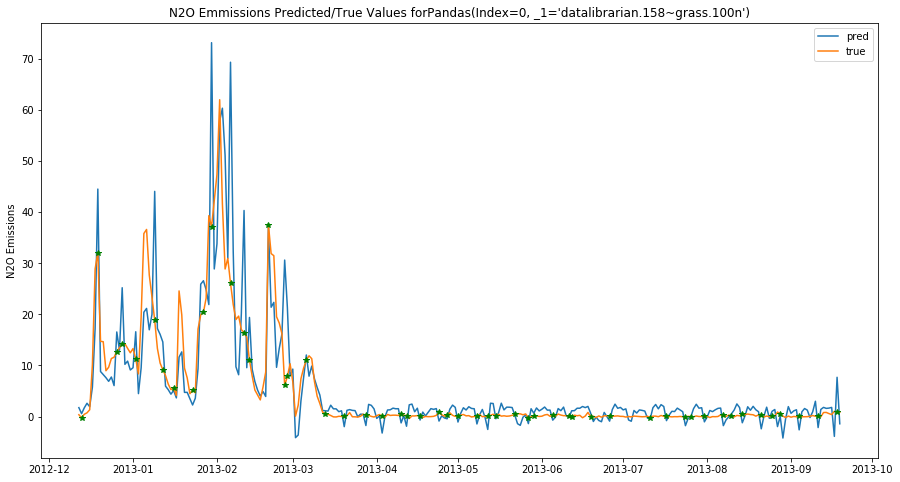

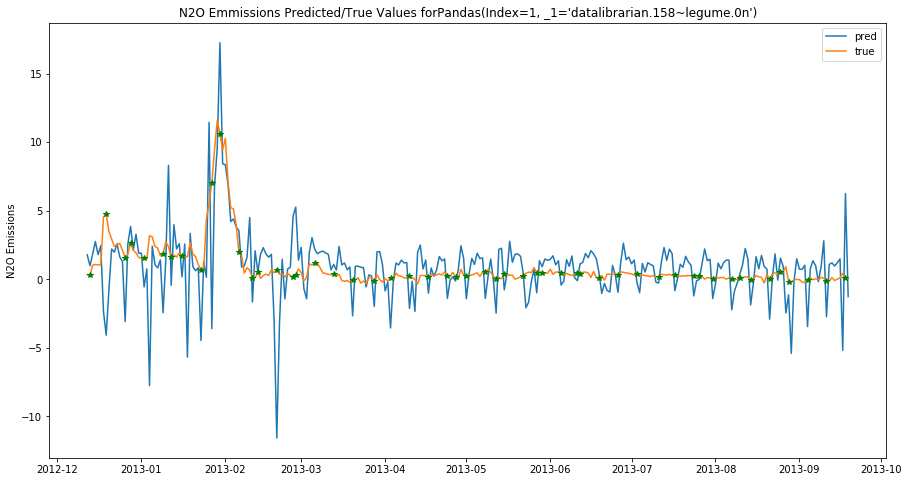

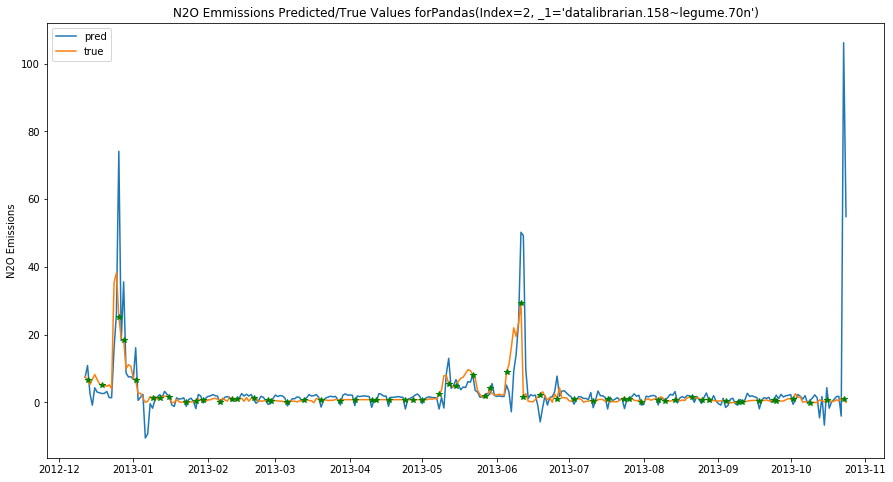

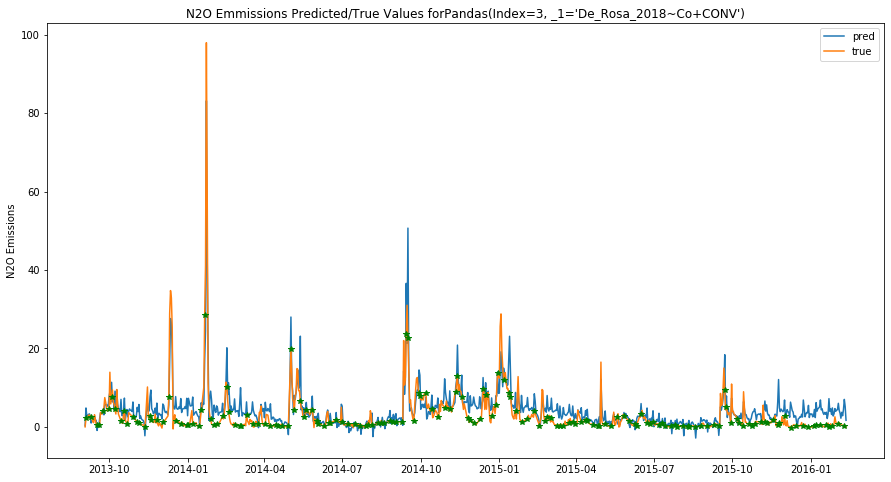

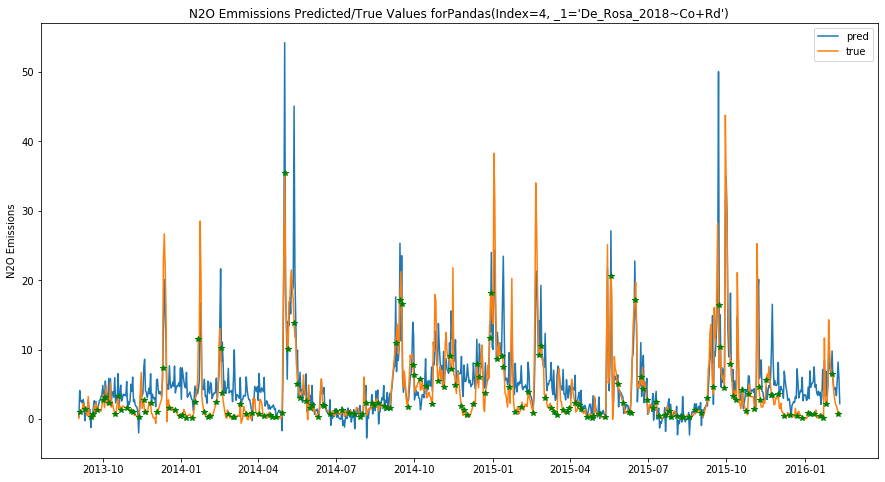

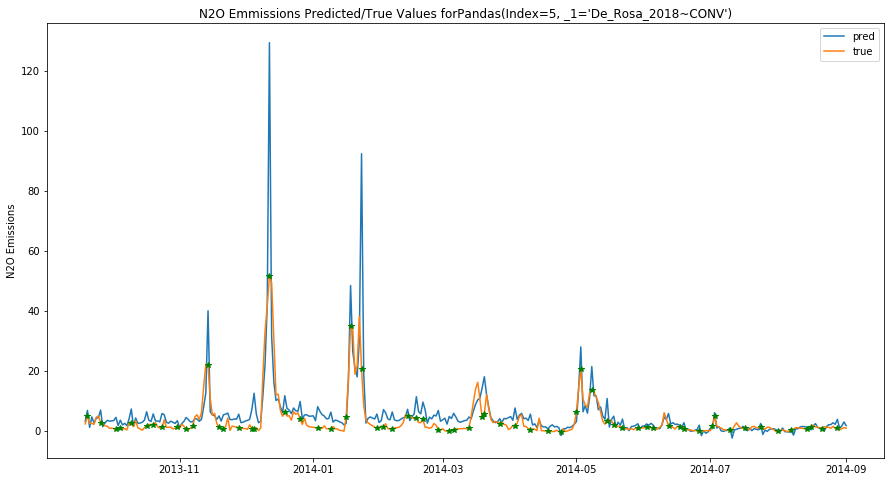

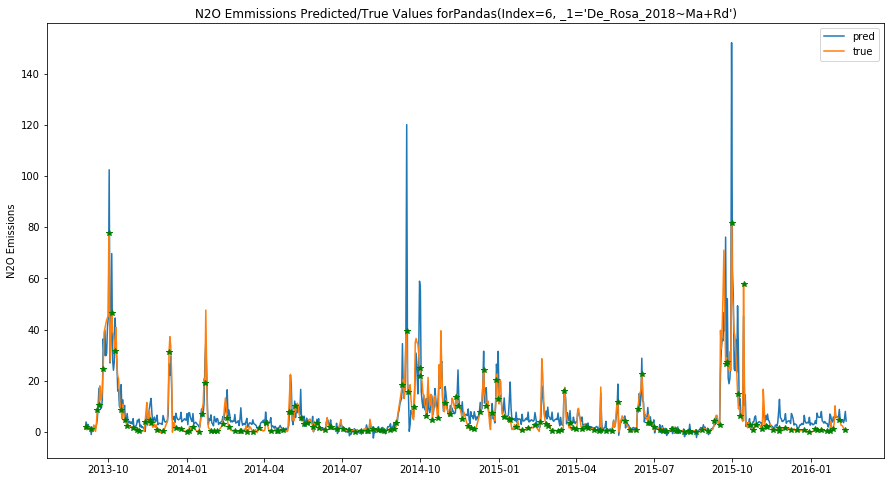

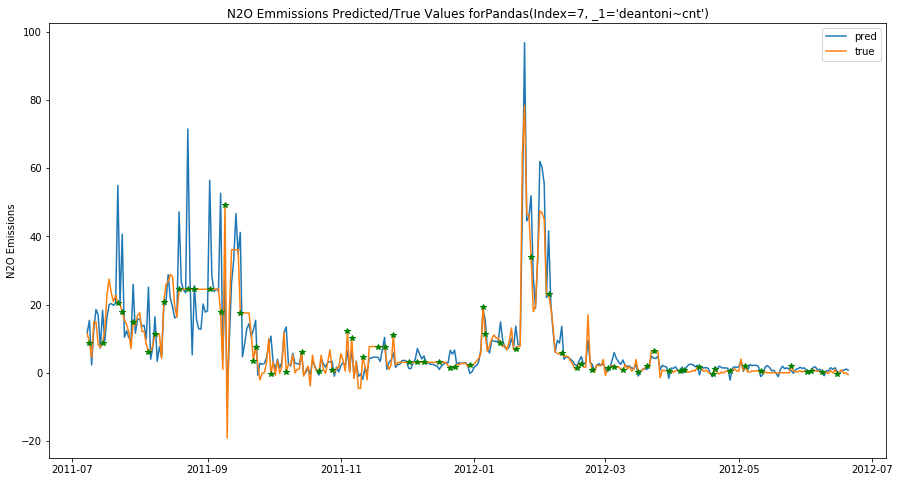

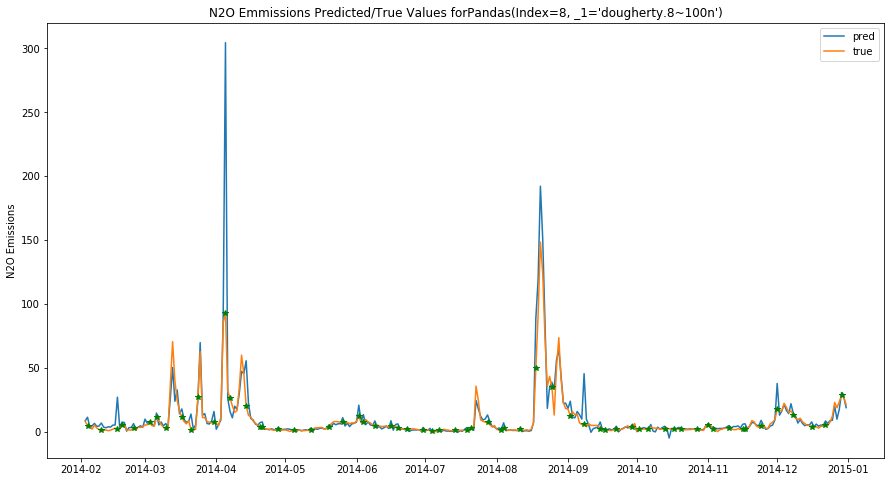

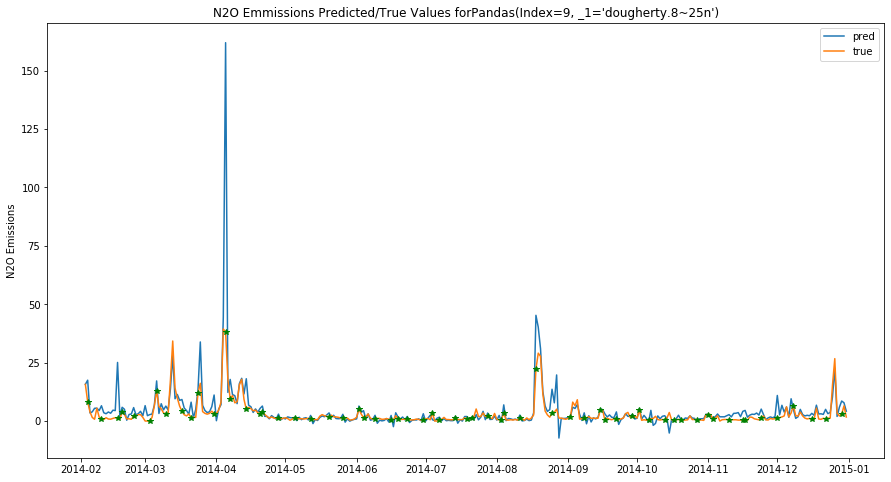

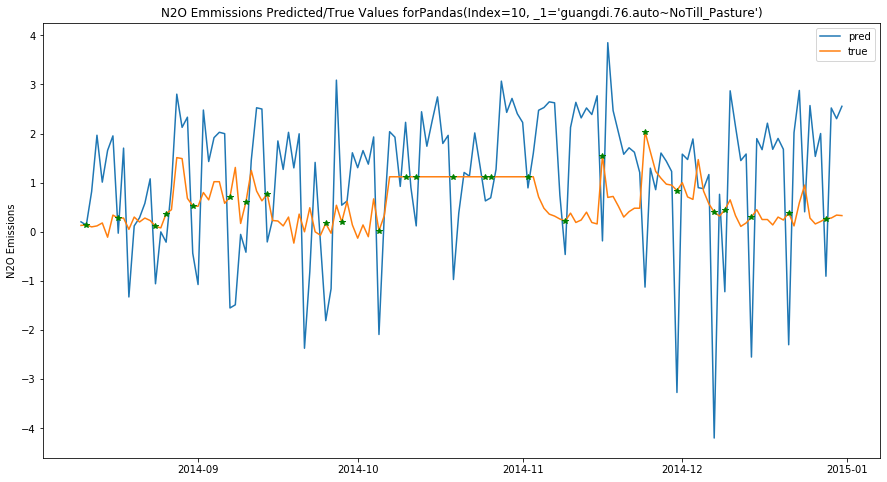

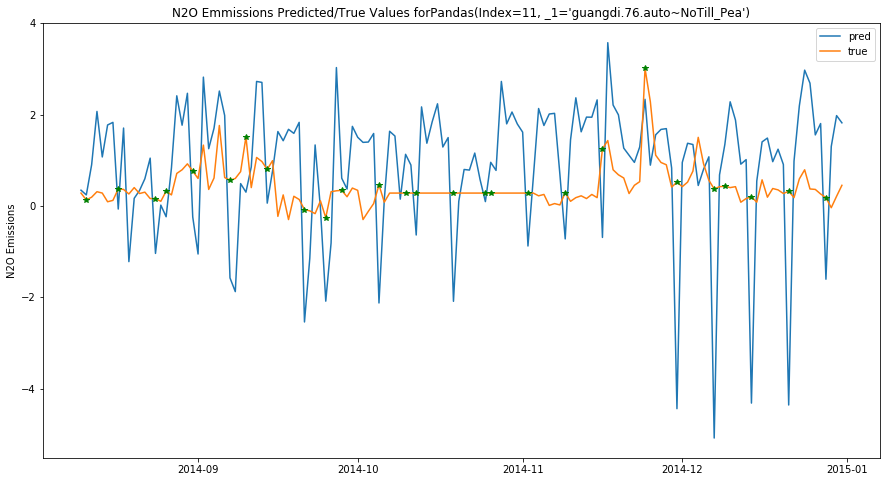

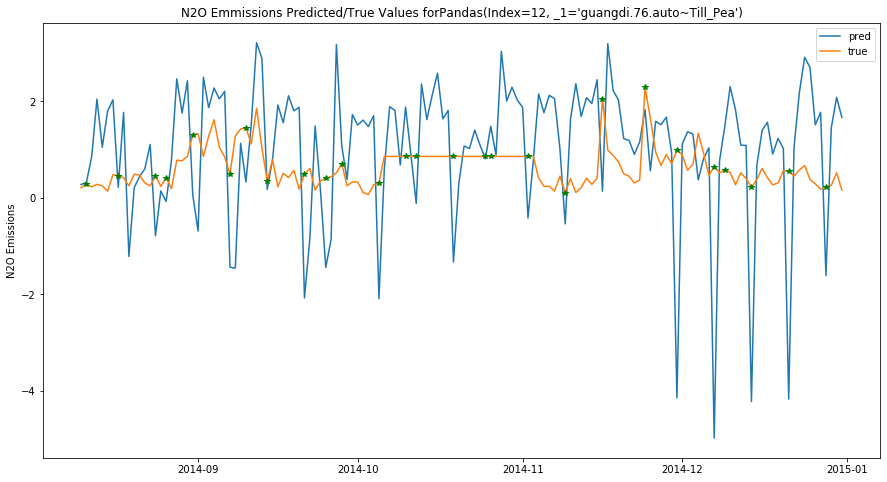

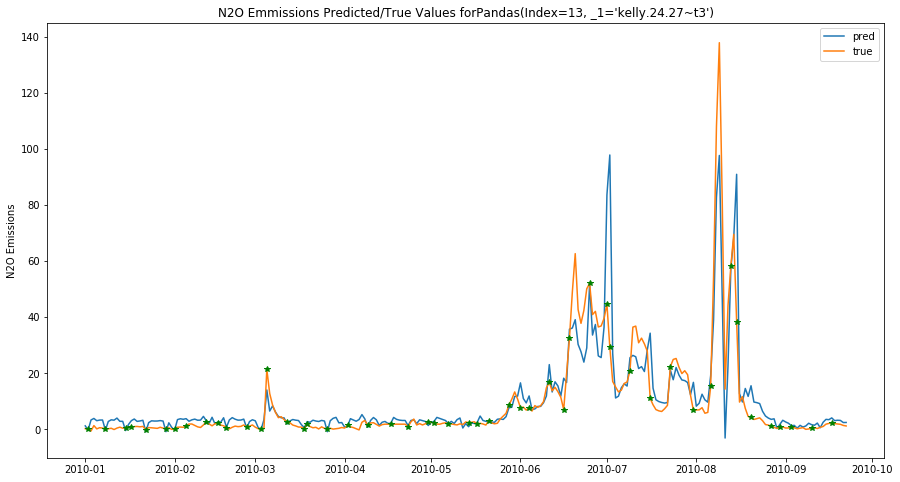

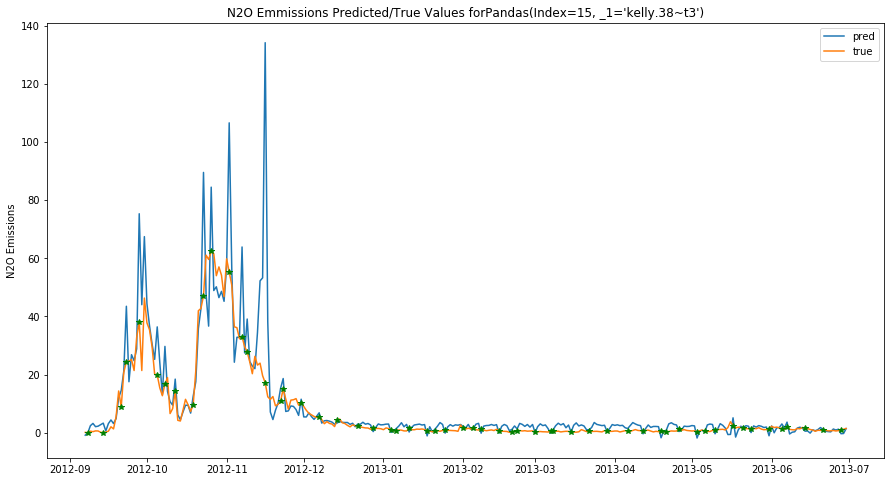

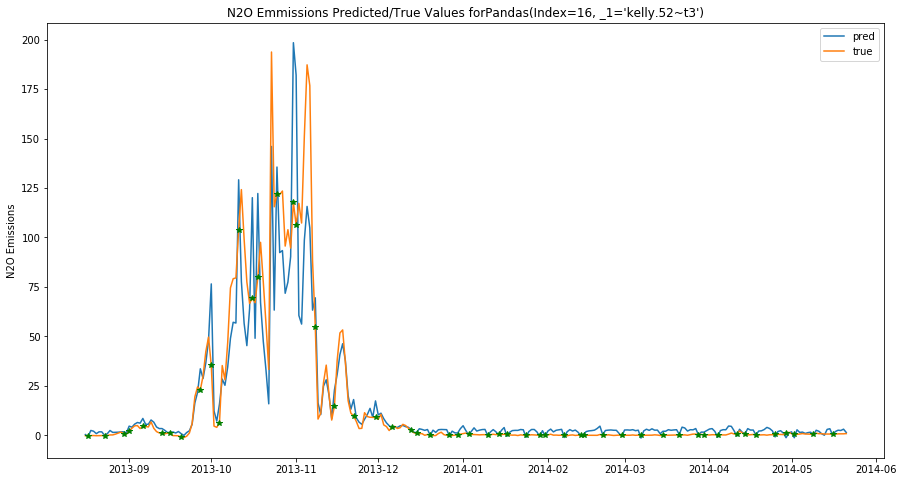

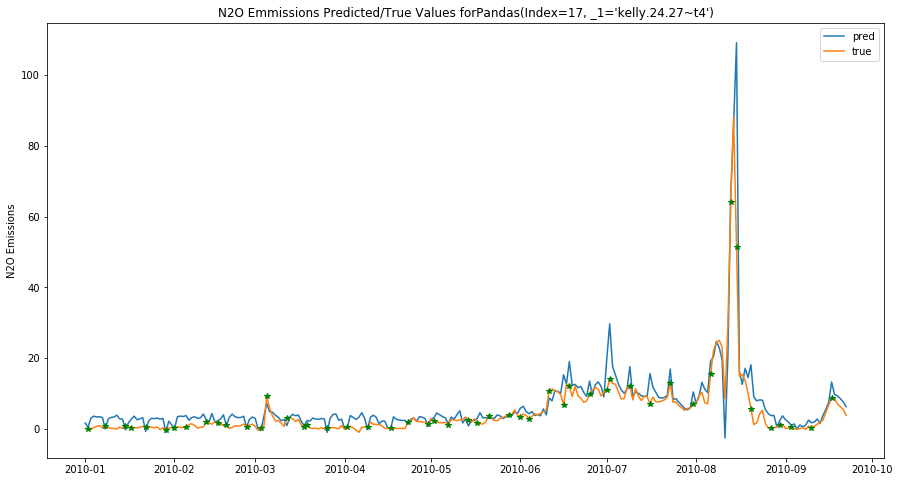

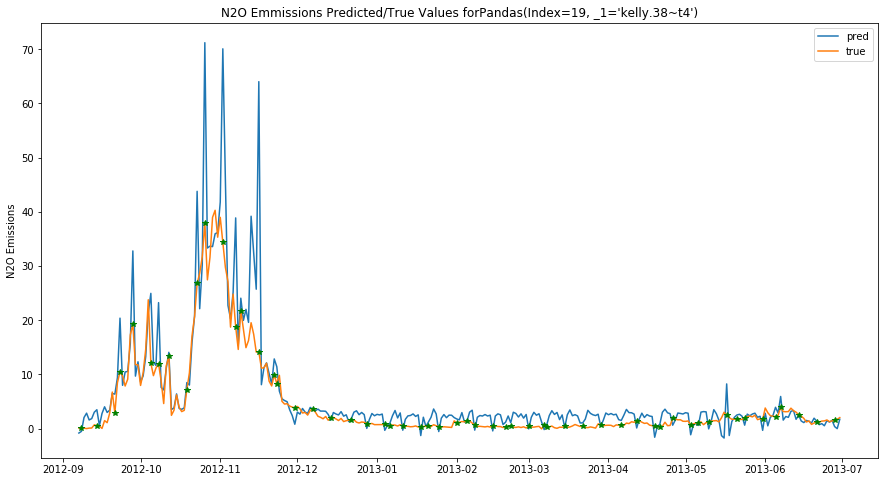

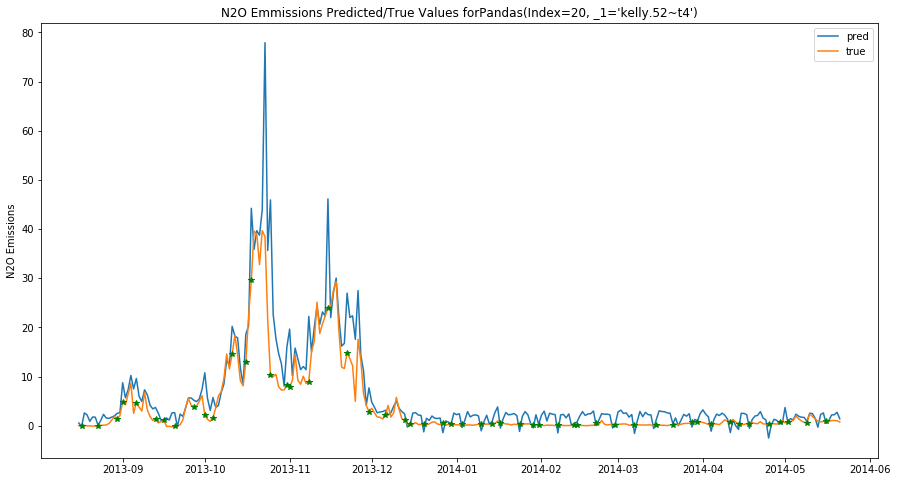

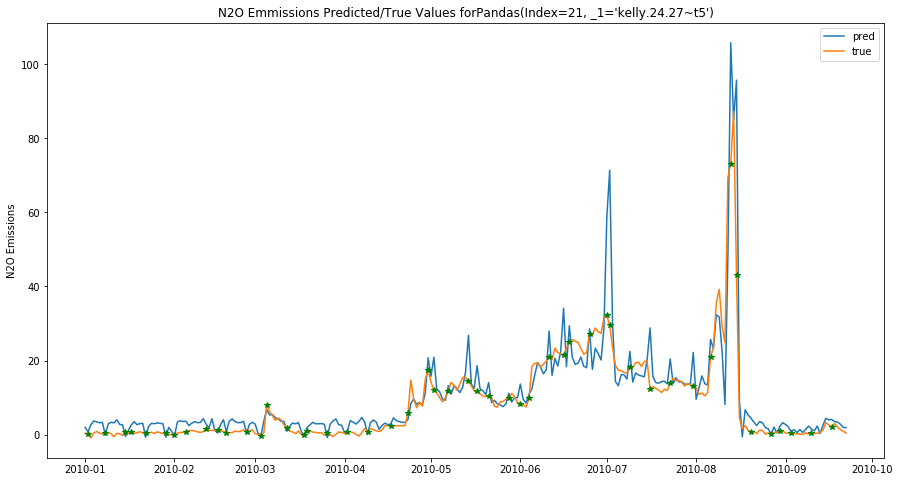

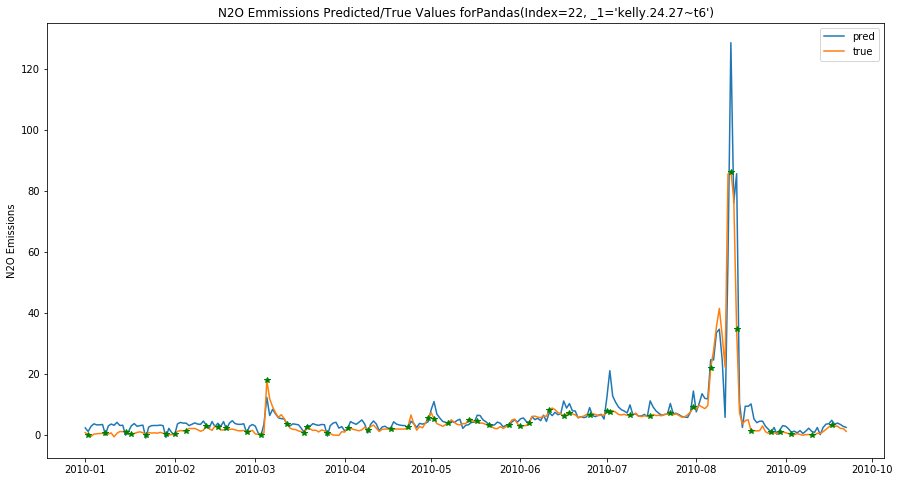

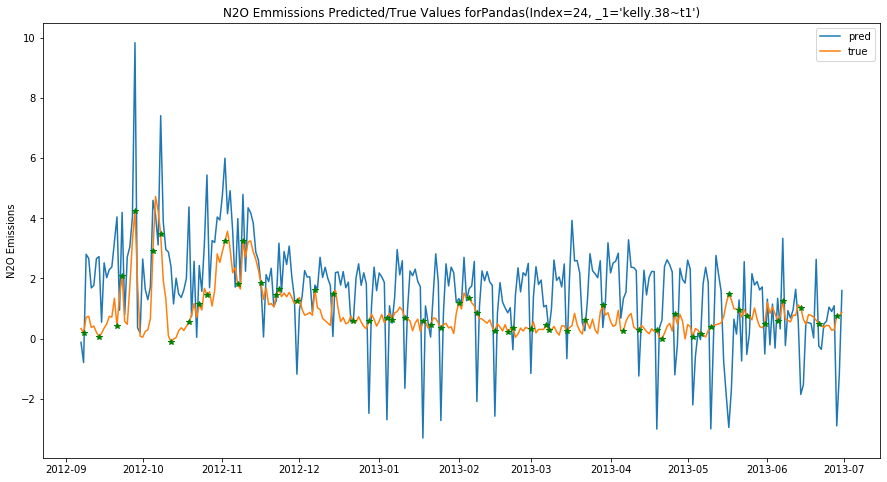

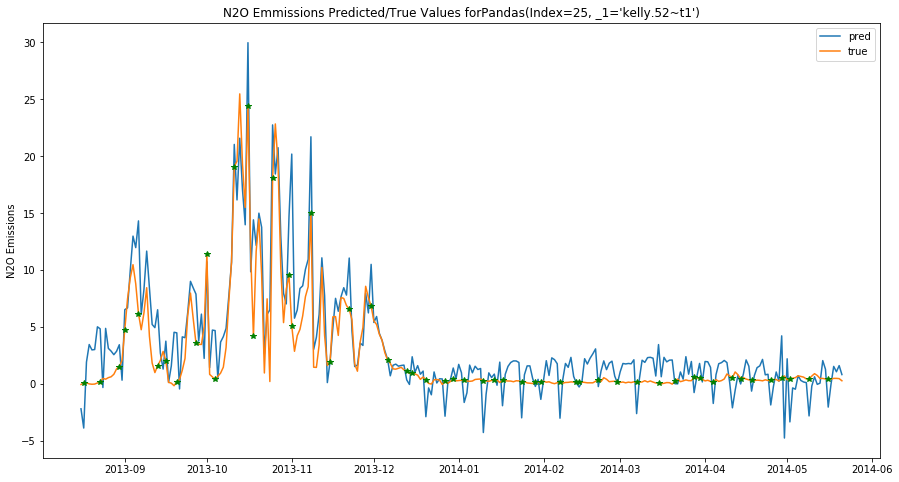

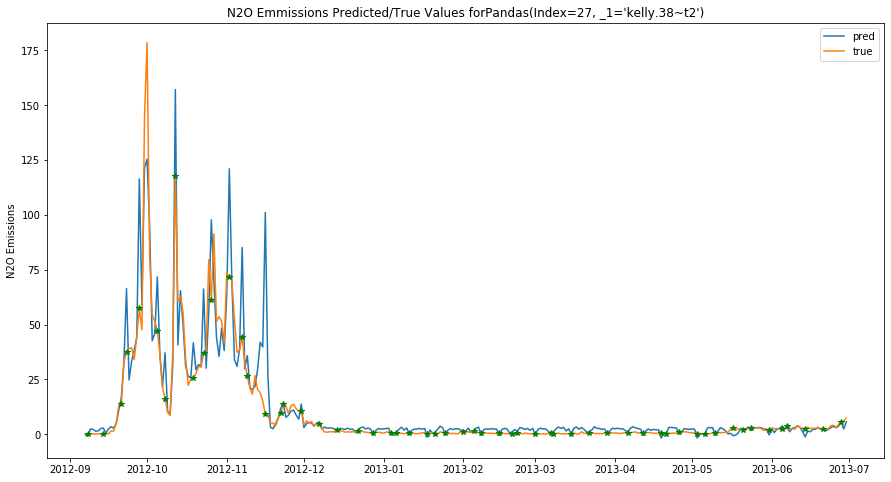

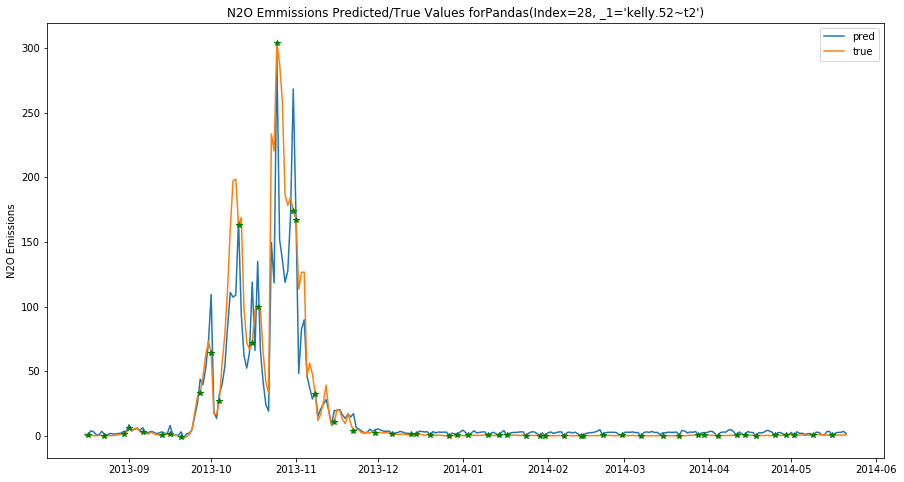

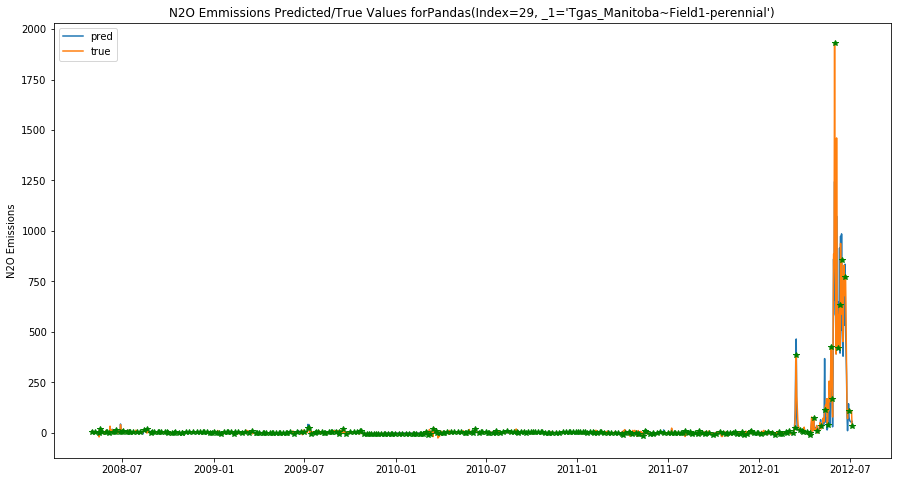

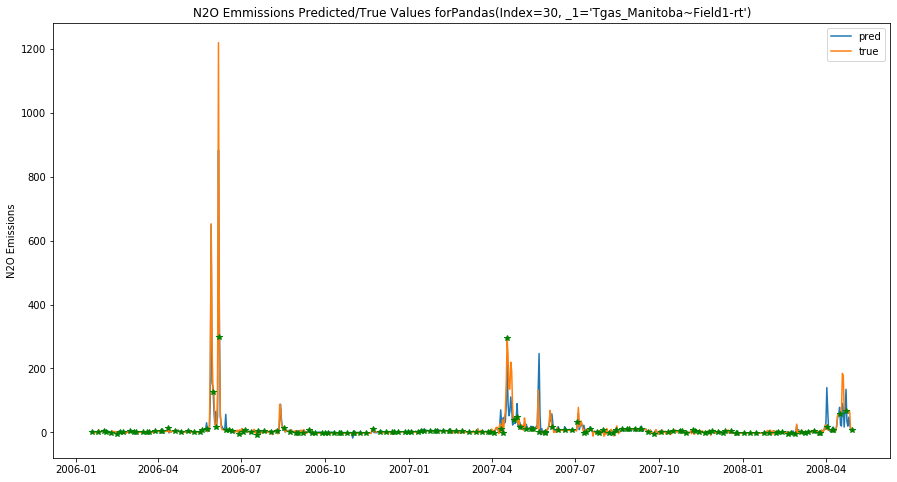

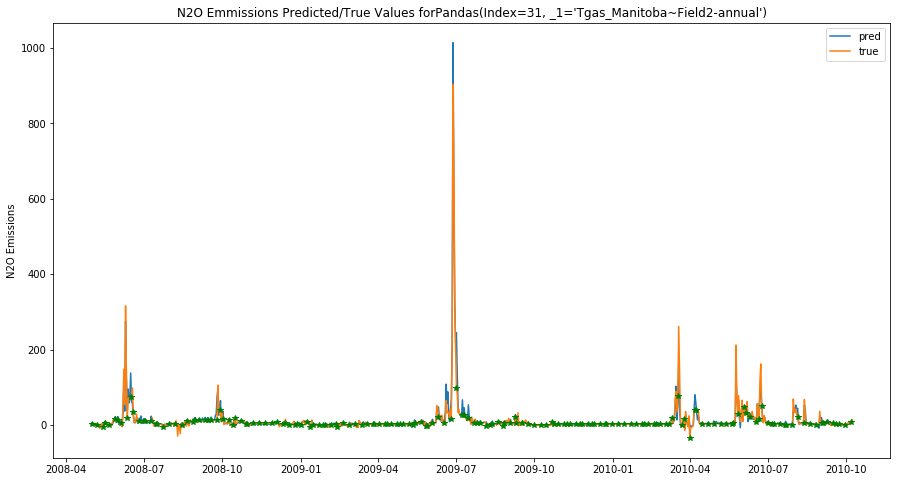

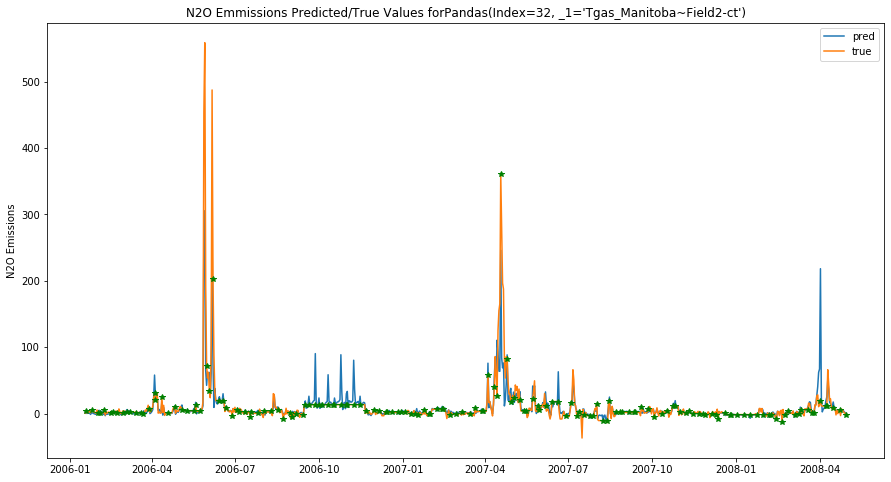

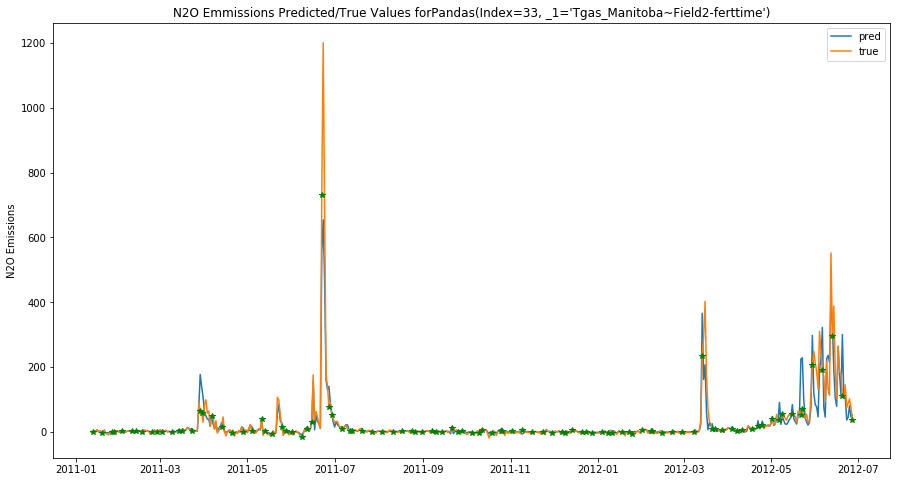

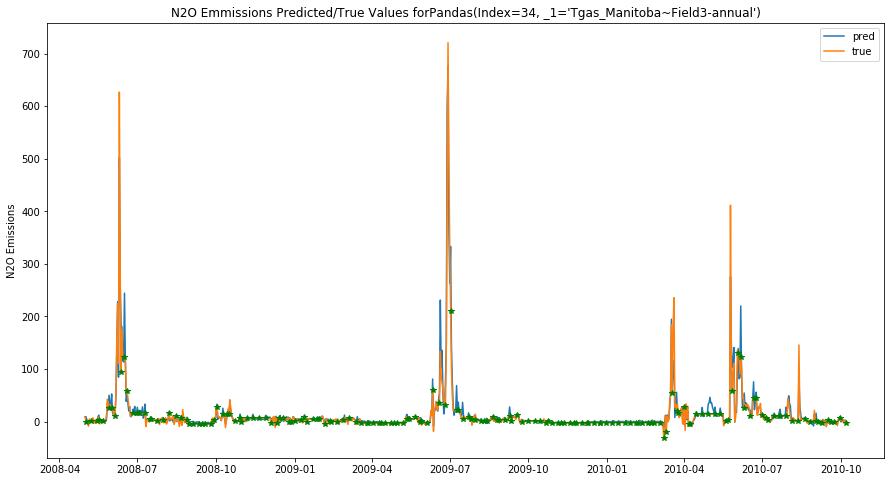

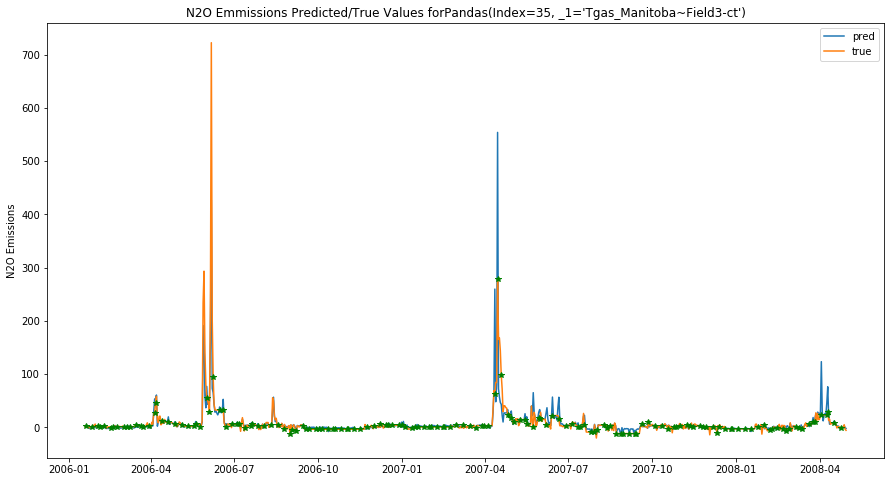

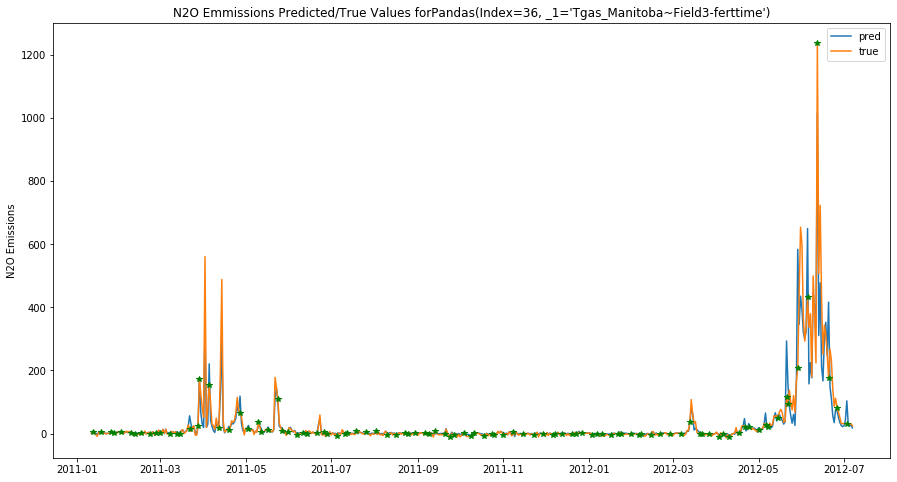

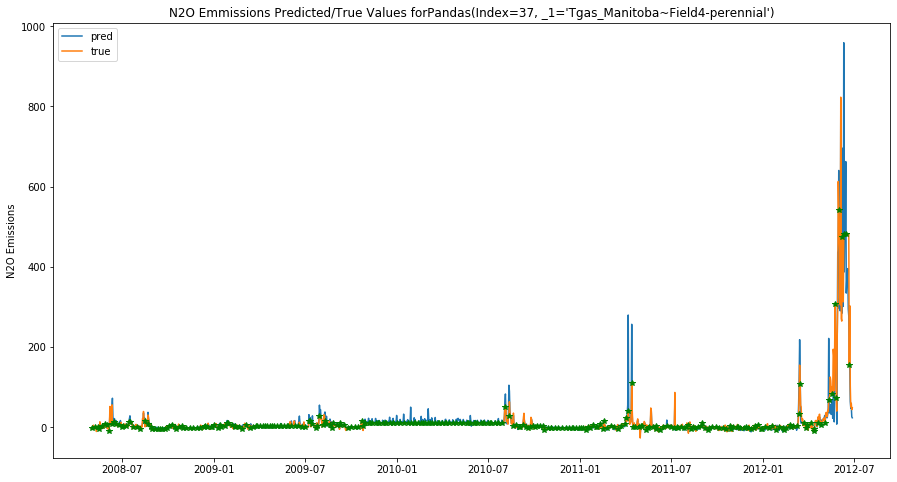

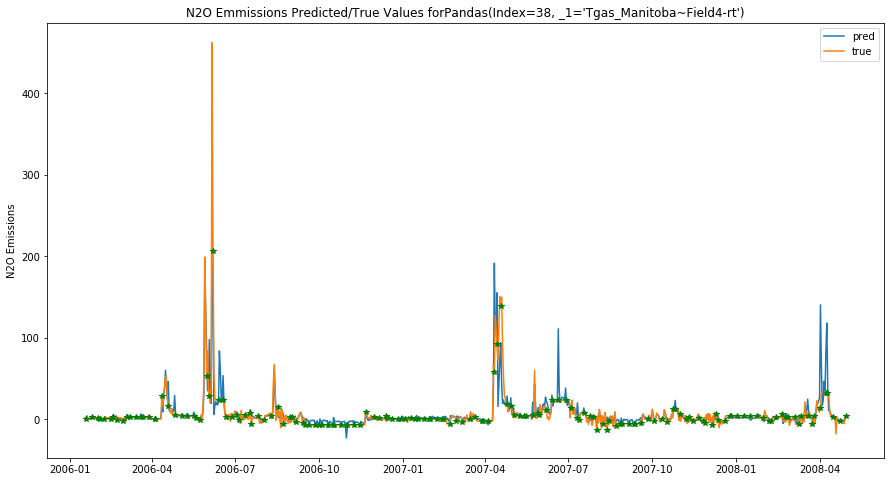

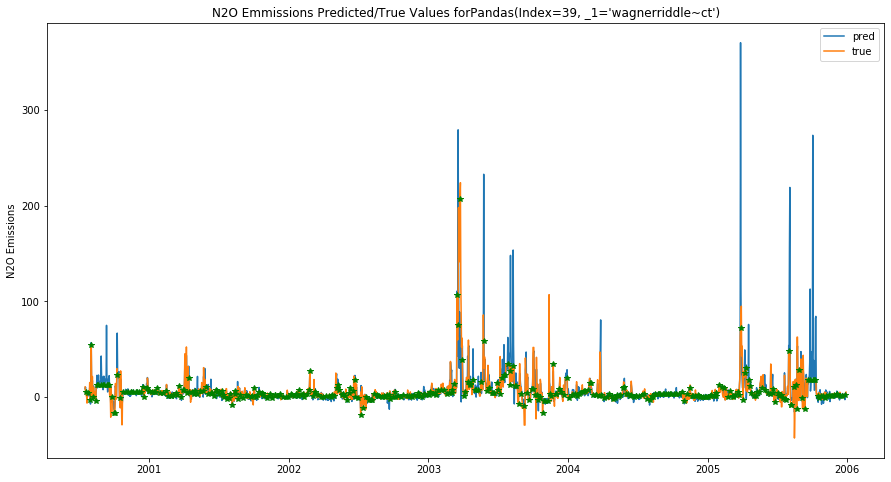

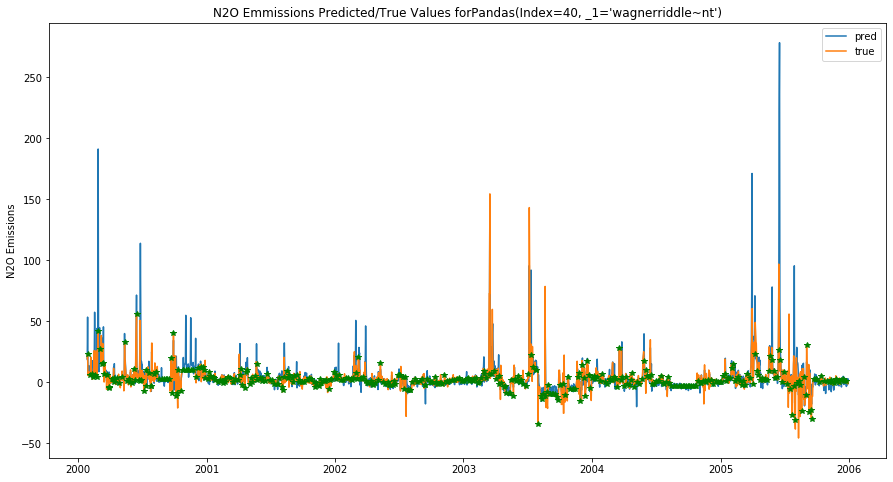

In [26]:
#this function runs the estimations for all sites and treatments and gets the plots to output


#create a list of all unique sites so that we can compare with rawtab and get values for each unique site plus treatment

import math 
n2ocell = []
rain = []
wfpscell = []
soiltempcell = []
raincell = []
co2cell = []
ind1 = []
l = []
dailytimeseries=[]
Rolling_3day_MSE = []
Rolling_5day_MSE  = []
Rolling_7day_MSE = []
Rolling_14day_MSE = []
MeanSquaredErr = []
Rollingav = []
for sites in dfsiteslistnew :   #dfsiteslistnew for all sites 
# for sites in dfsiteslistnewholdout:    # hold out set 5/6 cov without days since  
# for sites in dfsiteslistholdout:
    sitename = sites[1].split('~')[0]
    treatment = sites[1].split('~')[1]
    data = dfclean.loc[(dfclean['SiteID'] == sitename) & (dfclean['Treatment'] ==treatment)]
     
#     data = dfholdout.loc[(dfholdout['SiteID'] == sitename) & (dfholdout['Treatment'] ==treatment)]
#     data = dfholdout.loc[(dfholdout['SiteID'] == sitename) & (dfholdout['Treatment'] ==treatment)]
#     l.append(sitename+treatment)
    
 
    if sitename == "guangdi.76.auto":
        height, width = data.shape 
        data = data.iloc[110:height,:]
        #ind1.append(data)
        
         
        
         
        
#         break
    elif (sitename == "dougherty.8") & (treatment =='25N') :
        height, width = data.shape 
        data = data.iloc[110:height,:]
         
        
         
 
 

 
#     elif (sitename == "dougherty.8") & (treatment =='100N'):
#         height, width = data.shape 
#         data = data.iloc[111:height,:]
#         ind1.append(data)
#         print('here we are')
#         print(ind1)
#         break 
         
    
    elif sites == "dougherty.8~50N":
        height, width = data.shape 
        data = data[18:height,:]
        ind1.append(data)
        print('here we are')
          
    #get height and width of the data frame to slice out as we wish 
    height, width = data.shape 
    # pull out all the sequences from the raw data and initiate data pre-processing 
    n2oseq = data.n2o
    irrigation=data['rainirrigation'] #change the variabe/column name acc to the dataset used
#     rainplusirri = pd.concat([irrigation,irrigation])
    rain=data.rain
     
    
     
    dates = np.asarray(data.Date).reshape((-1,1))
    
    
    
    
#     dates = pd.to_datetime(dates) 
     
     
    
    
    sampidxn2oq = np.zeros(height)
    sampidxn2oq[::7]= 1  #try giving n2o samples every 3 day 
#     sampidxn2oq[::3]= 1 
    ex1 = sampidxn2oq[::7]
#     ex1 = sampidxn2oq[::3]
    mask = sampidxn2oq ==1  #use mask to find out where sampidxn2oq values are 1
    index  = n2oseq[mask].isnull().values #finding out the null values in n2oseq where the samplidxn2oq is 1. 
    ex1[index]=0 #dimensions of the indices was smaller than the original sampidxn2oq series so we had to use another series ex1 to trim it 
    sampidxn2oq[::7] = ex1
#     sampidxn2oq[::3] = ex1
    idx = n2oseq.isnull() 
    idx1 = n2oseq.notnull() 
     
     
     
    sampidxn2oq[idx]=0   # put zeros at the indices of n2oseq where there are nan values
#     print(n2oseq[0:1].notnull())
    
    # checking out the non nan or or nan? values in each of those sites for n2oseq and replacing those indices in sampidxn2o with zero values 
    #and finding the next non nan value in n2oseq and replacing that index in sampidxn2o with 1. Using 15 day window in this process
    
    for i in range(0,height - 15,15):
        
          if(n2oseq[0:i+1].notnull().any()):
            sampidxn2oq[i]=0
            first_non_NaN_index_of_X = n2oseq[i:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
            
          elif(n2oseq[i+4:i+5].notnull().any()):
            sampidxn2oq[i+4]=0
            first_non_NaN_index_of_X = n2oseq[i+4:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
          elif(n2oseq[i+8:i+9].notnull().any()):
            sampidxn2oq[i+8]=0
            first_non_NaN_index_of_X = n2oseq[i+8:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
          elif(n2oseq[i+12:i+13].notnull().any()):
            sampidxn2oq[i+12]=0
            first_non_NaN_index_of_X = n2oseq[i+12:i+15].notnull()[0:1] 
            sampidxn2oq[i+first_non_NaN_index_of_X] = 1
        
    
        
        
#         if(n2oseq[0:i+1].notnull().any()):
#             sampidxn2oq[i]=0
#             first_non_NaN_index_of_X = n2oseq[i:i+15].notnull()[0:1] 
#             sampidxn2oq[i+first_non_NaN_index_of_X] = 1
            
#         elif(n2oseq[i+6:i+7].notnull().any()):
#             sampidxn2oq[i+6]=0
#             first_non_NaN_index_of_X = n2oseq[i+6:i+15].notnull()[0:1] 
#             sampidxn2oq[i+first_non_NaN_index_of_X] = 1
#         elif(n2oseq[i+11:i+12].notnull().any()):
#             sampidxn2oq[i+11]=0
#             first_non_NaN_index_of_X = n2oseq[i+11:i+15].notnull()[0:1] 
#             sampidxn2oq[i+first_non_NaN_index_of_X] = 1
        
        
        
         
        
        
        
    k = rain
    wfpsseqq = data.WFPS  
    soilseq = data['soiltemp10'] #why is the soiltemp10real used here, shouldn't it be just soiltemp10 instead?
    fertseq = data['Fertilizerapplied']
    dayssinceappseq = data['DaysSinceApp']
#     NO3seq = data.NO3
    n2oseq.interpolate(inplace = True)
    n2oseq.fillna(method='bfill', inplace = True)
    y = n2oseq   #target values used during prediction to check error. Used in the 'plot_comparison' function
     
    samps = np.asarray(n2oseq*sampidxn2oq).reshape((-1,1))
    samps[samps == 0]=np.nan
     
     
    n2oseq = (n2oseq - meantrain[0])/sigmatrain[0]
    rain = (rain - meantrain[1])/sigmatrain[1]
    soilseq = (soilseq -meantrain[5])/sigmatrain[5]
#     NO3seq = (NO3seq -meantrain[3])/sigmatrain[3]
    
    fertseq = (fertseq -meantrain[2])/sigmatrain[2]
    dayssinceappseq = (dayssinceappseq -meantrain[4])/sigmatrain[4]
    wfpsseqq = (wfpsseqq - meantrain[3])/sigmatrain[3]
    sampidxn2oq = (sampidxn2oq - meantrain[6])/sigmatrain[6]
     
   
    
    
    #pad the data to make it equal in dimensions to the model prediction inputs. That is, make the number of samples
    #divisible by 60 and make sure to remove those values later after predicting and before plotting graphs 
    
    
        
        
#     d = {'n2oseq': n2oseq,'rain': rain,'soilseq':soilseq, 'NO3seq':NO3seq,'wfpsseq' : wfpsseqq,'sampidxn2oq':sampidxn2oq} 
#     d = {'n2oseq': n2oseq,'rain': rain,'wfpsseq' : wfpsseqq,'sampidxn2oq':sampidxn2oq} 
#     d = {'n2oseq': n2oseq,'rain': rain, 'soilseq':soilseq,'NO3seq': NO3seq,'wfpsseq' : wfpsseqq,'sampidxn2oq':sampidxn2oq}  #base is the dataframe for each site +treatment and now we will make 
#     d = {'n2oseq': n2oseq,'rain': rain, 'wfpsseq' : wfpsseqq,'fertseq':fertseq,'dayssinceappseq':dayssinceappseq, 'sampidxn2oq':sampidxn2oq} 
    d = {'n2oseq': n2oseq,'rain': rain,'fertseq': fertseq,'wfpsseq' : wfpsseqq,'dayssinceappseq':dayssinceappseq ,'soilseq':soilseq, 'sampidxn2oq':sampidxn2oq}
    base = pd.DataFrame(data = d)
     
     
     
    
    if (height%15) !=0:
        j = height // 15
        pad = pd.DataFrame(np.zeros(((j+1)*15-height, 7)))
         
        basedf = pd.DataFrame(np.vstack([base,pad]),columns=['n2oseq', 'rain','fertseq','wfpsseq','dayssinceappseq', 'soilseq', 'sampidxn2oq'])
#         basedf = pd.DataFrame(np.vstack([base,pad]),columns=['n2oseq', 'rain','wfpsseq', 'sampidxn2oq'])
         
#         basedf = pd.DataFrame(np.vstack([base,pad]),columns=['n2oseq', 'rain','soilseq','NO3seq','wfpsseq', 'sampidxn2oq'])
        result = plot_comparison(basedf, y_true = y, start_idx=0, length=15)
        MeanSquaredErr.append(result[0:14])
        Rollingav.append(result[14])
#         l.append(data.iloc[0:height,2:5])
        l.append(data.iloc[0:height,[0,1]]) #change the indices acc to the columns index of the dataframe(side+treatment
        dailytimeseries.append(result[15])
#         Rolling_3day_MSE.append(result[4])
#         Rolling_5day_MSE.append(result[5])
#         Rolling_7day_MSE.append(result[6])
#         Rolling_14day_MSE.append(result[7])
#         Rollingav.append(result[13])
        
         
   
         
    
         
        
    
    
    
    
    
    
    #site level changes/mising values population/ or any other changes inside this dataframe and also try to use it to predict for each site+treatment 
#     n2oseq.interpolate(inplace = True)    #interpolated the values of n2oseq linearly where they were null 
#     n2oseq.fillna(method='bfill', inplace = True)   #some trailing nan values occurred at edges and they were filled suing backward fill
#     n2oseq = (n2oseq - meantrain[0])//sigmatrain[0]
#     rain = (rain - meantrain[1])//sigmatrain[1]
#     wfpsseq = (wfpsseq - meantrain[2])//sigmatrain[2]
#     sampidxn2oq = (sampidxn2oq - meantrain[3])//sigmatrain[3]
                
    #create a base dataframe to make it easy to calculate mse and to plot 
#     base = pd.DataFrame(data = d)
#     base.append(pad)
    
     
    ind1.append(basedf)
     
        
    #now we will have to standardize the data and divide them into batches before we can feed them into the prediction model 
    
    #now we can start predicting using out model weights 
    
    
    
    
    
    
    # create plots with each of those sites + treatments and save them 
    
    
    
    
    
    
    
    
    
    #create tables for rmse/mse values for each of those 
    
    
    
    
     
    
    
    
    
    
    
    
    
    
     
    
# appended_data = pd.concat(ind1)
 
# appended_data


 
 

 

 
 

#     l.append(rain.isnull().any())
#     l.append(np.where(np.isnan(irrigation))[0])
#     k[np.where(np.isnan(irrigation))[0]]  = rain[np.where(np.isnan(irrigation))[0]] # not really using rain irrigation as of now 
#     k[np.where(np.isnan(rain))[0]] = rainplusirri[np.where(np.isnan(rain))[0]]
#     b[np.where(np.isnan(b))[0]]  = a[np.where(np.isnan(b))[0]]
 

    
 
    

    
#     % k = nan*ones(size(rain)); % creates cell of all NaN
#     k(isnan(irrigation)) = rain(isnan(irrigation)); % in locations where rainirrigation is NaN, use rain value
#     k(isnan(rain)) = irrigation(isnan(rain));

 
 





   
 
 
    
#     n2ocell.append(data.n2o)
#     wfpscell.append(data.WFPS)
#     rain  = data.rain 
#     irrigation = data.rainirrigation 
#     rain[rain.isnull()]=irrigation[rain.isnull()]
#     raincell.append(rain)

     





In [27]:
#get time series tables and error plots and save them to the required destination path
appended_data = pd.DataFrame(pd.concat(dailytimeseries))
appended_data.reset_index(inplace=True, drop=True)
appended_data_sites = pd.DataFrame(pd.concat(l))
appended_data_sites.reset_index(inplace=True, drop=True)
result = pd.concat([appended_data_sites, appended_data], axis=1)
# column_names = ["Site", "Treatment", "Dates", "True","Predicted", "samplesgiven" ]
# result = result.reindex(columns=column_names)
sum(result['Predicted'].isnull())
# result.drop(['id_loc'], axis=1, inplace=True)
# result =result[['Dates', 'SiteID', 'Treatment','True', 'Predicted', 'samplesgiven']]
# result
# result.to_csv('/Users/abhijnannath/LSTM N2o/Outputclippingplots/Cross Valid Holdout /final trainsets for keras after matlab/sample18/trainset results/Time series /7_day_sampling/crossvalid_train18_timeseries_30day_base_LSTM_4cov_DO20_SL30.csv')


0

In [28]:
appended_data = pd.concat(ind1)
 
Error_Table = pd.DataFrame(MeanSquaredErr, columns=['Site+Treatment', 'RMSE','NormalisedRMSE', 'Mean_Abs_Error', 'NormalisedMAE','Rsquared','3dayRollav','5dayRollav', '7dayRollav','14dayRollav', ' Rolling_3day_MSEMedian', ' Rolling_5day_MSEMedian', ' Rolling_7day_MSEMedian',' Rolling_14day_MSEMedian'])
# Error_Table.to_csv('/Users/abhijnannath/LSTM N2o/Outputclippingplots/Cross Valid Holdout /final trainsets for keras after matlab/sample18/trainset results/Error table /7_day_sampling/crossvalid_train18_errortable30day_base_LSTM_4cov_DO20_SL30.csv')
Error_Table

,Site+Treatment,RMSE,NormalisedRMSE,Mean_Abs_Error,NormalisedMAE,Rsquared,3dayRollav,5dayRollav,7dayRollav,14dayRollav,Rolling_3day_MSEMedian,Rolling_5day_MSEMedian,Rolling_7day_MSEMedian,Rolling_14day_MSEMedian
0,datalibrarian.158~grass.100n,5.924704,0.094947,3.027026,0.048510,0.643414,3.480844,3.636486,3.732003,3.941044,1.538688,1.546073,1.523399,1.504739
1,datalibrarian.158~legume.0n,2.217287,0.186014,1.485339,0.124609,-0.742590,1.721117,1.806846,1.851531,1.922003,1.262409,1.372063,1.377330,1.432016
2,datalibrarian.158~legume.70n,8.342123,0.217469,2.577705,0.067198,-2.103957,2.870551,2.959721,3.035705,3.224652,1.262231,1.318180,1.311956,1.256686
3,De_Rosa_2018~Co+CONV,3.191754,0.032416,2.199451,0.022338,0.684864,2.446464,2.543756,2.605902,2.709553,1.963515,2.050543,2.239845,2.507034
4,De_Rosa_2018~Co+Rd,3.629778,0.081820,2.411264,0.054353,0.563043,2.748977,2.880039,2.963476,3.099166,2.230860,2.419138,2.644050,2.935030
5,De_Rosa_2018~CONV,6.610541,0.126939,2.702077,0.051887,0.057473,3.214300,3.481427,3.663023,4.080493,1.953676,2.301203,2.468097,2.557103
6,De_Rosa_2018~Ma+Rd,6.168774,0.075213,3.131246,0.038178,0.620767,3.682140,3.885369,4.009821,4.235692,2.491004,2.892597,2.992069,3.358912
7,deantoni~cnt,6.264217,0.064269,3.087595,0.031678,0.686288,3.874663,4.153769,4.283829,4.523859,1.769734,2.081975,2.233423,2.321101
8,dougherty.8~100n,13.219203,0.089100,3.565413,0.024032,0.392607,4.617438,5.204547,5.617833,6.575357,1.860759,2.074486,2.145749,2.376920
9,dougherty.8~25n,7.570936,0.192020,2.208568,0.056016,-1.132097,2.839158,3.181535,3.420608,3.901692,1.422747,1.619452,1.549504,1.827415
